# 第5部　正規線形モデル｜Pythonで学ぶ統計学入門

## 3章　複数の説明変数を持つモデル

売上予測モデルにおいて、湿度・気温・天気（晴れ or 雨）・価格という4つの説明変数を用いる。

天気はカテゴリ型の変数であり、それ以外は連続型の変数である。複数の説明変数を持っていても、正規線形モデルという枠組みで統一的な分析と解釈・予測が可能である。

分散分析においては、Type ll ANOVAと呼ばれる検定手法の解説も行う。複数の説明変数があった場合に、それらの変数の有意性をどのように判定するかを学ぶ。

### 分析の準備

In [1]:
# 数値計算に使うライブラリ
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats

# グラフを描画するライブラリ
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

# 統計モデルを推定するライブラリ(ワーニングが出ることもあります)
import statsmodels.formula.api as smf
import statsmodels.api as sm

# 表示桁数の指定
%precision 3
# グラフをjupyter Notebook内に表示させるための指定
%matplotlib inline

/Users/kaito/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


あるお店における架空の売上データを`sales`という名称で保存する。

In [2]:
# データの読み込み
sales = pd.read_csv("5-3-1-lm-model.csv")
print(sales.head(3))

   humidity  price  sales  temperature weather
0      29.5    290  229.7         17.8   rainy
1      38.1    290  206.1         26.1   rainy
2      31.5    290  202.5         22.0   rainy


### 実装：データの図示

とりあえず図示。

今回は複数の説明変数があるため、ペアプロットを出力する。

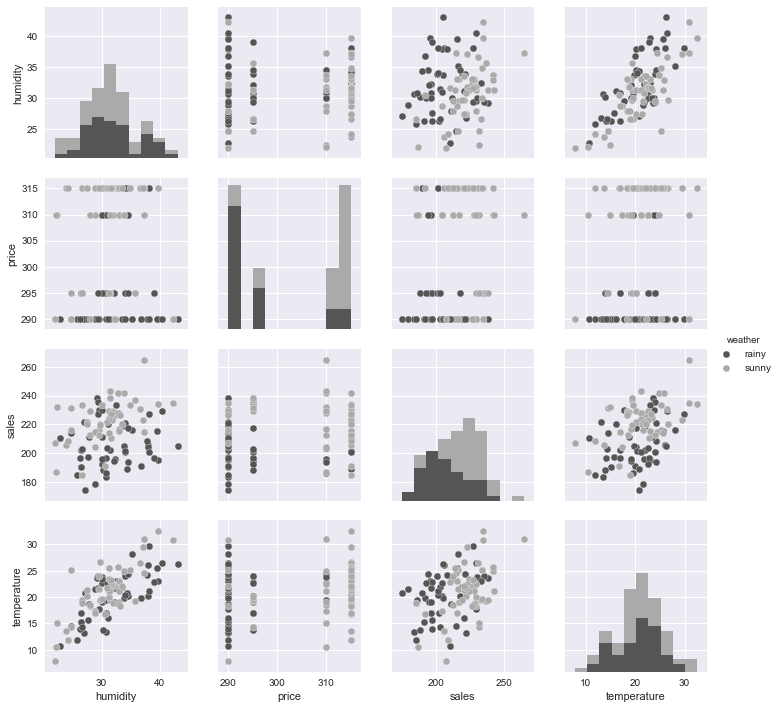

In [3]:
# データの図示
sns.pairplot(data = sales, hue = "weather", 
             palette="gray")

予測したいのはsalesなので、3行目（Y軸が売上）にまず注目してみる。このグラフだけだとどんな影響を受けているのか判別が難しい。

一目でわかる点としては、湿度と気温の関係性。気温が{高い、低い}と湿度も{高い、低い}ということがわかる。

### 悪い分析例：変数が1つだけのモデルを作る

複数の説明変数を持つモデルを作成する前に、悪い分析例を示す。

In [4]:
# 売り上げを、価格だけを用いてモデル化
lm_dame = smf.ols("sales ~ price", sales).fit()
lm_dame.params

Intercept    113.645406
price          0.332812
dtype: float64

説明変数に価格だけを使い、単回帰モデルを推定する。価格の係数が正の値（0.332812）となった。


In [5]:
# 価格の係数は有意に0と異なる
print(sm.stats.anova_lm(lm_dame, typ=2))

                sum_sq    df         F    PR(>F)
price      1398.392322   1.0  4.970685  0.028064
Residual  27570.133578  98.0       NaN       NaN


分散分析を用いて検定すると、$p$値（0.028064）が0.05を下回った。

結果をまとめると、価格は売上に対して有意な影響を持っており、価格が上がると売上も増えるということになる。
考察としては、売上を増やしたければ、単に価格を上げればよいという考察ができそうである。

`lmplot`で散布図と回帰直線を引いてみると↓のようになる。

/Users/kaito/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


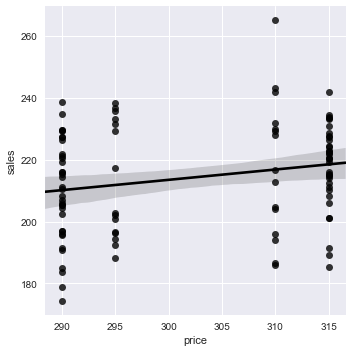

In [6]:
# 価格と売り上げの関係
sns.lmplot(x = "price", y = "sales", data = sales,
           scatter_kws = {"color": "black"},
           line_kws    = {"color": "black"})

### 説明変数同士の関係を調べる

先ほどの分析のどこが問題かというと、お店側の都合を無視して価格と売上の関係だけを取り出していたから。

お店はどのようにして価格を日々変化させているか、ごく簡単な集計の工夫によりそれを明らかにすることができる。
groupby関数で天気別に平均値を集計してみる。

In [7]:
# お天気別の集計
print(sales.groupby("weather").mean())

         humidity  price    sales  temperature
weather                                       
rainy      32.126  295.5  205.924       20.422
sunny      30.852  309.5  222.718       21.102


これを見ると、売上は雨のときに低くなっている。

さらに雨の日のほうが低い価格に抑えられている。これは「雨の日には売上が下がるので、その対策としてお店が値引きをしていた」と考えるの自然である。
雨の日には売上が下がるので、価格を安くした日にもやはり売上は相対的に下がるように見えることになる。

ここで、気になるのは「天気が同じだったときの商品価格が売上にもたらす影響」。

/Users/kaito/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


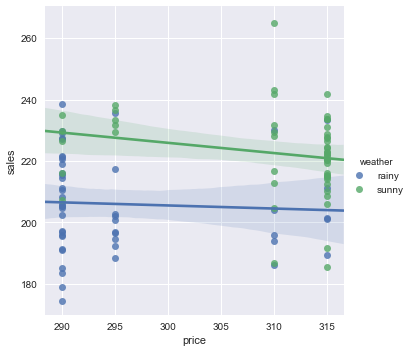

In [8]:
# 天気別に分けた、価格と売り上げの回帰直線
sns.lmplot(x = "price", y = "sales", data = sales, 
           hue="weather")

晴れの日（緑）の方が高い売上になっていること、そして天気別で見ると「価格が高くなると、売上が下がる」ということがわかる。
これは先ほどと全く逆の結論となった。

過去には、天気によってデータを分割し、分割されたデータに対して回帰分析を行うという手法も使われることがあった。
晴れのデータのみを使って価格と売上の関係を調べ、雨の日のデータはまた別に回帰分析にかけるという方法。
しかし、このやり方では係数の検定を行う際、晴れの日と雨の日で2回検定を繰り返すことになり、検定の多重性の問題が発生する。

各要因の影響を正しく判断するためには、複数の説明変数を持つモデルを一発で推定しなければならない。

### 実装：複数の説明変数を持つモデル

次に、説明変数が4つすべて入ったモデルを推定する。
説明変数同士を「＋」記号で連結することで、複数の説明変数をモデルに組み込むことができる。

In [9]:
# 複数の説明変数を持つモデルを推定する
lm_sales = smf.ols(
    "sales ~ weather + humidity + temperature + price",
    data=sales).fit()
# 推定された結果
lm_sales.params

Intercept           278.627722
weather[T.sunny]     19.989119
humidity             -0.254055
temperature           1.603115
price                -0.329207
dtype: float64

先ほどの悪い分析例と異なり、価格の係数が負になっている。

このことから価格が上がると売上が下がるということがわかった。

### 悪い分析例：通常の分散分析で検定する

説明変数が応答変数に影響を与えているのか、検定を用いて判断する。このとき、素朴な分散分析を行うのは実は問題がある。

`typ=1`と指定して素朴な分散分析を行う。これはType 1 ANOVAとも呼ばれる。

In [10]:
# 通常の分散分析
print(sm.stats.anova_lm(lm_sales, typ=1).round(3))

               df     sum_sq   mean_sq       F  PR(>F)
weather       1.0   7050.961  7050.961  38.848   0.000
humidity      1.0   1779.601  1779.601   9.805   0.002
temperature   1.0   2076.845  2076.845  11.443   0.001
price         1.0    818.402   818.402   4.509   0.036
Residual     95.0  17242.717   181.502     NaN     NaN


/Users/kaito/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/kaito/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/kaito/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


この結果を見ると、すべての説明変数が有意となった。

しかし、この検定結果は誤り。
Type 1 ANOVAは説明変数を入れる順番を変えると、検定の結果が変わってしまう。

それを確かめるために、変数を入れる順番を変えて全く同じ4つの説明変数を持つ正規線形モデルを推定してみる。

In [11]:
# 説明変数の順番を変える
lm_sales_2 = smf.ols(
    "sales ~ weather + temperature + humidity + price",
    data=sales).fit()
# 検定結果
print(sm.stats.anova_lm(lm_sales_2, typ=1).round(3))

               df     sum_sq   mean_sq       F  PR(>F)
weather       1.0   7050.961  7050.961  38.848   0.000
temperature   1.0   3814.779  3814.779  21.018   0.000
humidity      1.0     41.667    41.667   0.230   0.633
price         1.0    818.402   818.402   4.509   0.036
Residual     95.0  17242.717   181.502     NaN     NaN


/Users/kaito/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/kaito/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/kaito/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


変更点は、説明変数を入れる順番を気温と湿度で逆にしただけ。

* モデル1：sales ~ weather + humidity + temperature + price 
* モデル2：sales ~ weather + temperature + humidity + price 

順番を変えただけなので、推定された係数の値などは一致するが、検定結果は一致しない。

モデル2では湿度(humidity)の$p$値が0.6ほどになり、売上に有意な影響を与えないという結果となった。

### 実装：回帰係数のt検定

分散分析をやめて、回帰係数の$t$検定をするとこの問題は起こらない。

係数とその検定の結果のみを載せる。

In [12]:
# モデル1の回帰係数のt検定
lm_sales.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,278.6277,46.335,6.013,0.000,186.641,370.615
weather[T.sunny],19.9891,3.522,5.675,0.000,12.997,26.982
humidity,-0.2541,0.456,-0.558,0.578,-1.159,0.651
temperature,1.6031,0.443,3.620,0.000,0.724,2.482
price,-0.3292,0.155,-2.123,0.036,-0.637,-0.021


変数の順番を変えたモデルの検定結果は↓のようになる。

In [13]:
# モデル2の回帰係数のt検定
lm_sales_2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,278.6277,46.335,6.013,0.000,186.641,370.615
weather[T.sunny],19.9891,3.522,5.675,0.000,12.997,26.982
temperature,1.6031,0.443,3.620,0.000,0.724,2.482
humidity,-0.2541,0.456,-0.558,0.578,-1.159,0.651
price,-0.3292,0.155,-2.123,0.036,-0.637,-0.021


湿度の回帰係数の$p$値はともに0.578となっている。

回帰係数の$t$検定ならば説明変数の順番がもたらす問題は発生しないことがわかった。
しかし、今回は天気というカテゴリ型の変数が「晴れor雨」の2つだけであった。仮に、「曇り」という天気があった場合、天気の影響を$t$検定で判断することは2章で解説したように検定の多重性の問題が生じてしまう。

### 3-8 Type ll ANOVA

説明変数を入れる順番を変えても検定結果が変わらない分散分析を**Type ll ANOVA**と呼ぶ。

今回のような場合はType ll ANOVAを使うのが望ましい。

### モデル選択と分散分析

まずは複数の説明変数を持つモデルに対するType l ANOVAの計算方法について学ぶ。

以下の順番で変数を組み込んだモデルについて考える。頭についた1は切片を表す。

$$sales\ \tilde \ weather + humidity + termperature + price$$

変数を1つずつ増やしていく。
最初は説明変数のないNullモデルを推定する。
このときの残差平方和の大きさを求める。


In [14]:
# Nullモデルの残差平方和
mod_null = smf.ols("sales ~ 1", sales).fit()
resid_sq_null = sp.sum(mod_null.resid ** 2)
resid_sq_null

28968.526

次に、説明変数に天気だけを入れたモデルの残差平方和を求める。

In [15]:
# 天気モデルの残差平方和
mod_1 = smf.ols("sales ~ weather", sales).fit()
resid_sq_1 = sp.sum(mod_1.resid ** 2)
resid_sq_1

21917.565

残差平方和の差を求める。

In [16]:
# 残差平方和の差
resid_sq_null - resid_sq_1

7050.961

この値は分散分析表にも登場する。

In [17]:
print(sm.stats.anova_lm(mod_1).round(3))

            df     sum_sq   mean_sq       F  PR(>F)
weather    1.0   7050.961  7050.961  31.527     0.0
Residual  98.0  21917.565   223.649     NaN     NaN


/Users/kaito/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/kaito/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/kaito/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


天気が変わることによる”群間の偏差平方和”は「モデルに天気という説明変数を加えることによって減少する残差平方和」と一致するということです。

さらに説明変数humidityを追加して残差平方和を求める。

In [18]:
# 天気+湿度モデルの残差平方和
mod_2 = smf.ols(
    "sales ~ weather + humidity", sales).fit()
resid_sq_2 = sp.sum(mod_2.resid ** 2)
resid_sq_2

20137.964

「天気だけ」が入ったモデルの残差平方和から「天気＋湿度」が入ったモデルの残差平方和を引く。

In [19]:
# 残差平方和の差
resid_sq_1 - resid_sq_2

1779.601

残差平方和の差は、分散分析表にも現れる。

In [20]:
print(sm.stats.anova_lm(mod_2).round(3))

            df     sum_sq   mean_sq       F  PR(>F)
weather    1.0   7050.961  7050.961  33.963   0.000
humidity   1.0   1779.601  1779.601   8.572   0.004
Residual  97.0  20137.964   207.608     NaN     NaN


/Users/kaito/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/kaito/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/kaito/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


例えばhumidityの$F$比は「$1779.601 \div 207.608$」で計算される。
分母は常に誤差の大きさ（207.608）が使われるので、weatherの$F$比は「$7050.961 \div 207.608$」で計算される。

すなわち分散分析は、説明変数を1つずつ増やしていき、「説明変数が増えることによって減少する残差平方和の大きさ」に基づいて「説明変数の持つ効果の大きさ」を定量化していることになる。

この手法だと、説明変数を増やしていくその順番が大きな意味を持ってしまう。

まずは「天気＋気温」を説明変数に持つモデルの残差平方和を求める。

In [21]:
# 天気+気温モデルの残差平方和
mod_2_2 = smf.ols(
    "sales ~ weather + temperature", sales).fit()
resid_sq_2_2 = sp.sum(mod_2_2.resid ** 2)
resid_sq_2_2

18102.786

次は「天気＋気温＋湿度」のモデル。

In [22]:
# 天気+気温+湿度モデルの残差平方和
mod_3_2 = smf.ols(
    "sales ~ weather + temperature + humidity",
    sales).fit()
resid_sq_3_2 = sp.sum(mod_3_2.resid ** 2)
resid_sq_3_2

18061.119

残差平方和の差を求めると「天気＋気温」のモデルに湿度を加えることによって減少した残差平方和が求まる。

In [23]:
resid_sq_2_2 - resid_sq_3_2

41.667

この値が「天気しか入ってなかったモデル(21917.565)に湿度を加えたとき(20137.964)の残差平方和の減少量(1779.601)」と比べると、小さな値になっていることに注目する。

これはすなわち「湿度の持つ効果の大きさが小さい」という意味であり、検定をすると$p$値は0.639となるので、湿度は売上に有意な影響をもっているとはいえないという結果となる。

In [24]:
print(sm.stats.anova_lm(mod_3_2).round(3))

               df     sum_sq   mean_sq       F  PR(>F)
weather       1.0   7050.961  7050.961  37.478   0.000
temperature   1.0   3814.779  3814.779  20.277   0.000
humidity      1.0     41.667    41.667   0.221   0.639
Residual     96.0  18061.119   188.137     NaN     NaN


/Users/kaito/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/kaito/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/kaito/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


まとめると、複数の説明変数を持つ場合の分散分析は、説明変数を1つずつ増やしていき、「説明変数が増えることによって減少する残差平方和の大きさ」に基づいて「説明変数の持つ効果の大きさ（分散分析表におけるsum_sq）」を計算する。

この方法だと、「説明変数を増やしていく順番」によってsum_sqの値が大きく変わってくるため、有意になるかならないかという判断も変わることがある。

この検定方法がType l ANOVAと呼ばれるもので、説明変数が複数ある場合に誤った結果をもたらす可能性がある。

### 3-10 Type II ANOVAと調整平方和

Type l ANOVAは以下のように残差平方和を比較する。

* モデル0：売上 〜　　　　　　　　　　　　　　　　　　　＋　残差平方和
* モデル1：売上 〜　天気　　　　　　　　　　　　　　　　＋　残差平方和
* モデル2：売上 〜　天気　＋　湿度　　　　　　　　　　　＋　残差平方和
* モデル3：売上 〜　天気　＋　湿度　＋　気温　　　　　　＋　残差平方和
* モデル4：売上 〜　天気　＋　湿度　＋　気温　＋　価格　＋　残差平方和

モデル0と1の残差平方和の比較、モデル1と2の残差平方和の比較……を通して各々の説明変数の有意性を検定する。

Type ll ANOVAは以下のように残差平方和を比較する。

* モデル0：売上 〜　天気　＋　湿度　＋　気温　＋　価格　＋　残差平方和
* モデル1：売上 〜　　　　　　湿度　＋　気温　＋　価格　＋　残差平方和
* モデル2：売上 〜　天気　＋　　　　　　気温　＋　価格　＋　残差平方和
* モデル3：売上 〜　天気　＋　湿度　　　　　　＋　価格　＋　残差平方和
* モデル4：売上 〜　天気　＋　湿度　＋　気温　　　　　　＋　残差平方和

モデル0と1、モデル0と2といったように、すべてモデル0の残差平方和と比較する。

Type ll ANOVAは「説明変数が減ることによって増加する残差平方和の大きさ」に基づいて「説明変数の持つ効果の大きさ」を定量化していると考えるとわかりやすいでしょう。このやり方ならば、変数を入れる順番を変えても、検定の結果は変わることがない。この方法で計算された”群間の偏差平方和”は**調整平方和**と呼ばれる。

### 実装：Type II ANOVA

調整平方和を計算する。

まずは全ての説明変数が含まれたモデルを構築し、残差平方和を求める。

In [25]:
# すべての変数を入れたモデルの残差平方和
mod_full = smf.ols(
    "sales ~ weather + humidity + temperature + price",
    sales).fit()
resid_sq_full = sp.sum(mod_full.resid ** 2)
resid_sq_full

17242.717

続いて、湿度だけを取り除いたモデルを構築する。

In [26]:
# 湿度だけ除いたモデルの残差平方和
mod_non_humi = smf.ols(
    "sales ~ weather + temperature + price", 
    sales).fit()
resid_sq_non_humi = sp.sum(mod_non_humi.resid ** 2)
resid_sq_non_humi

17299.142

残差平方和の差は以下の通り。

In [27]:
# 調整平方和
resid_sq_non_humi - resid_sq_full

56.425

調整平方和を用いた分散分析であるType ll ANOVAは`typ=2`という引数をつけることで実行できる。

In [28]:
# Type II ANOVA
print(sm.stats.anova_lm(mod_full, typ=2).round(3))

                sum_sq    df       F  PR(>F)
weather       5845.878   1.0  32.208   0.000
humidity        56.425   1.0   0.311   0.578
temperature   2378.017   1.0  13.102   0.000
price          818.402   1.0   4.509   0.036
Residual     17242.717  95.0     NaN     NaN


$p$値は0.578なので、湿度は売上に対して有意な影響をもっているといえないという結果となった。

説明変数が1つしかない場合は、Type l ANOVAの結果とType ll ANOVAの結果と一致する。
検定結果の解釈の容易さを考え、この本ではType ll ANOVAの使用を推奨している。

なお、2つのモデルを直接比較する関数も用意されている。

In [29]:
# 2つのモデルを比較
mod_full.compare_f_test(mod_non_humi)

(0.311, 0.578, 1.000)

出力の3つの数値は順番に、$F$比、$p$値、2つのモデルの自由度の差。

### 3-12 Type ll ANOVAの解釈

Type ll ANOVAで湿度の影響を検定した結果は「他の説明変数があるという状況で、それでも湿度は売上に影響を及ぼしていると判断できるか」を調べたものだと解釈できる。

湿度は気温と強い相関があった。すると、「気温という説明変数がモデルに含まれていると、湿度は売上に影響を与えているとみなすことができなくなる」というような状況がありうる。

### 実装：変数選択

Type ll ANOVAを使って、変数選択を進めていく。
湿度はモデルに必要がないことがわかったので、湿度を抜いたモデル`mod_non_humi`で再度Type ll ANOVAを実行する。

In [30]:
print(sm.stats.anova_lm(mod_non_humi, typ=2).round(3))

                sum_sq    df       F  PR(>F)
weather       6354.966   1.0  35.266   0.000
temperature   4254.736   1.0  23.611   0.000
price          803.644   1.0   4.460   0.037
Residual     17299.142  96.0     NaN     NaN


有意でない変数が1つもなくなった。ここまでやって変数選択終了。

係数などの結果の解釈は、変数選択後のモデルを用いて行う。誤った変数の組み合わせでモデル化された結果を、予測や解釈に使うべきではない。

モデルの係数は以下の通り。

In [31]:
mod_non_humi.params

Intercept           273.301800
weather[T.sunny]     20.393871
temperature           1.417860
price                -0.326001
dtype: float64

`weather[T.sunny]`は、雨の日と比べると売上が20増えるということを意味している。

### 実装：AICによるモデル選択

AICを用いて変数選択を試みる。AICだと分散分析のように計算方法を変える必要はなく、愚直にモデルを作っていき、AICを比較するだけ。

例えばすべての変数を含むモデルである`mod_full`と湿度を除いたモデルである`mod_non_humi`のAICを比較する。

In [32]:
print("全変数入りモデル：", mod_full.aic.round(3))
print("湿度抜きモデル　：", mod_non_humi.aic.round(3), "\n")
print("Nullモデル：", mod_null.aic.round(3))
print("天気モデル：", mod_1.aic.round(3))
print("天気+湿度モデル：", mod_2.aic.round(3))
print("天気+気温モデル：", mod_2_2.aic.round(3))
print("天気+気温+湿度モデル：", mod_3_2.aic.round(3))

全変数入りモデル： 808.785
湿度抜きモデル　： 807.112 

Nullモデル： 852.667
天気モデル： 826.775
天気+湿度モデル： 820.307
天気+気温モデル： 809.653
天気+気温+湿度モデル： 811.422


湿度を除いたモデルのAICの方が小さくなった。

このため、やはり湿度は売上予測モデルからは除くべきだということになる。

AICによるモデル選択は、手順としてほぼ機械的に実行できる。係数の$t$検定と異なり、複数のカテゴリを持つ変数であっても検定の多重性を心配する必要がない。
得られたモデルの解釈も「未知データへの予測誤差を最小とするような変数の組み合わせが選ばれた」とみなすだけでよい。
検定の非対称性の問題もない。昨今のデータ分析においてAICが重要な役割を果たす大きな理由として、使い勝手のよさが挙げられる。

ただし、検定の$p$値を過剰に信じ込むのと同様に、AICへ過剰な信頼を寄せることにも問題がある。

得られた係数の解釈や変数選択の結果の解釈、残差のチェックなど、包括的な評価を行うことが望ましい。


### 3-15 多重共線性（multicollinearity、マルチコ）

説明変数同士に強い相関があるときに現れる問題が**多重共線性**。

今回のデータでは、気温と湿度に相関があった。このようなときはモデルの解釈に注意が必要になる。

多重共線性への対処として最も簡単なものが、<u>相関が強い変数のうち片方をモデルから取り除く</u>こと。
多重共線性があると、推定された係数の解釈が困難になる。また、変数選択のために検定を行うときにも変数同士にとても強い相関がある場合には、検定で得られる$p$値も解釈が難しくなる。

> 多重共線性によって引き起こされる症状は、
> 1. 分析結果における係数の標準誤差が大きくなる
> 1. t値が小さくなる
> 1. 決定係数が大きな値となる
> 1. 回帰係数の符号が本来なるべきものとは逆の符号となる
>
> などがあります。いずれも、正しく推計できなくなるような悪影響をもたらします。（[多重共線性とは？ 〜 概要と対応方法 〜](https://xica.net/vno4ul5p/)より）

[多重共線性によって重回帰分析の推定は不安定になる（のはなぜか？）](http://webbeginner.hatenablog.com/entry/2016/05/29/072806)に原因の解説がある。